### Semester Project              -              Master in Robotics              -              Yanis Bouadi (283606)



## Importing Libraries

In [1]:
# Packages
import os
import cv2
import skimage.io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import ndimage, misc
import scipy.interpolate
from math import cos, sin, degrees, radians, hypot
from skimage import measure, morphology, filters, data
import skimage.segmentation
from skimage.morphology import opening, erosion, square, closing, disk, dilation
from skimage.transform import rotate, rescale, SimilarityTransform
from MTM import matchTemplates, drawBoxesOnRGB


## Functions

In [2]:
def CREATE_Lab(image,mode,number_of_seeds,stage):
    
    nb_roots=number_of_seeds

    if stage=='early':
        threshold_depth=20  #minimum depth of a root (less than this threshold, it's not detected as a root)
    if stage=='late':
        threshold_depth=100

    im=image[:,:,0].copy()
    
    threshold_contour=0.6
    threshold_pixel=100
    thresh_v_min=30
    
    mean_im = int(image[:,:,0].mean())
    max_im  = int(image[:,:,0].max())
    min_im  = int(image[:,:,0].min())
    thre_im = (max_im + min_im)/2

    im[im>thre_im]=255  # Get a binary image
    im[im<=thre_im]=0
    
    K_min=nb_roots-5
    K_max=nb_roots+5
    

    # -------------------------------------------------------------------------------------------------#
    contours0 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')   
    nb_dilation,contours,nb_root_detected=0,[],[]
    Mode=0

    if mode=='Fast':
        Mode=1
    if mode=='Recommended':
        Mode=3
    if mode=='Accurate':
        Mode=5
    if mode=='Very Accurate':
        Mode=8

    # -------------------------------------------------------------------------------------------------#
    # In this while loop, we remove noisy contours: Narrow down the number of contour detected 
    # from thousands to a number around the number of seeds planted by binary thresholding AND dilation
    
    while(len(contours0) != nb_roots and nb_dilation<Mode):
        nb_dilation+=1
        ind=0  
        contours0 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')
        contours.append(contours0)

        # Size adaptive thresholding
        while ( len(contours0) < K_min or len(contours0) > K_max ):
            ind+=1

            if len(contours0)>nb_roots and threshold_pixel > 300:
                threshold_pixel = threshold_pixel + 10

            if len(contours0)<nb_roots and threshold_pixel > 300:
                im=skimage.color.rgb2gray(binary)
                contours0 = measure.find_contours(im,threshold_contour)
                threshold_pixel = threshold_pixel - 10

            for i in range(len(contours0)-1,-1,-1):
                v_min , v_max = min(contours0[i][:,0]) , max(contours0[i][:,0])

                if ( (len(contours0[i])<=threshold_pixel) or (v_max-v_min < threshold_depth) or (v_min)>thresh_v_min):
                    contours0[i]=[]        
                    contours0.remove([])

            if (ind > 130):  # To avoid infinite loop           
                break
        nb_root_detected.append(len(contours0))
        
        # Dilation fine tuning
        im=dilation(im)
        print(" Fine tuning in progress, please wait ...")
        print("")
        if nb_dilation>=Mode:
            break

    nb_root_detected= abs(nb_root_detected - nb_roots*np.ones(len(nb_root_detected)))
    ind_nb_rd=np.argmin(nb_root_detected)
    contours0=contours[ind_nb_rd]
    for e in range(Mode-ind_nb_rd):
        im=erosion(im)

    # -------------------------------------------------------------------------------------------------#
    # sort all the root regarding the horizontal axis
    
    fig, ax = plt.subplots(figsize=(9, 9))
    means,idx=[],[]

    for contour in contours0:
        
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        m=np.mean(contour,axis=0)
        means.append(m[1])
        idx=np.argsort(means)

        if contour[len(contour)-1][1]<contour[0][1]:
                contour=contour[::-1]

    contours0=[contours0[i] for i in idx] 
    ax.imshow(im,cmap='gray')




    # -------------------------------------------------------------------------------------------------#
    # Segmentation of the root into main and lateral roots + computing depth and length of lateral


    nb_segment,nb_lateral_root=[],[]
    main_roots,main_roots_depths,main_roots_lengths=[],[],[]
    lateral_roots,laterals_roots_depths=[],[]
    contours2=[]
    cnt_remove=0
    print(" Segmentation of lateral roots in progress, please wait ...")
    print("")
    for N in range(0,len(contours0)):

        contours1,black=[],[]
        black=image.copy()
        black[:,:,:]=0
        max_pos=0
        for s in range(2,len(contours0[N])):
            if (contours0[N][s-5][0]<contours0[N][s][0] and contours0[N][s][0]>max_pos ):
                max_pos=max(max_pos,contours0[N][s][0])
                black[int(contours0[N][s][0]),int(contours0[N][s][1]),: ] = 255
        
        black=dilation(black) ; black=dilation(black) ; black=dilation(black)
        im=black[:,:,0].copy()

        contours1 = measure.find_contours(im,threshold_contour, fully_connected='low',positive_orientation='low')   
        contours2.append(contours1)
        
        black=erosion(black) ; black=erosion(black) ; black=erosion(black)
        nb_segment.append(len(contours1))
    black=dilation(black) ; black=dilation(black) ; black=dilation(black)

    for j in range(len(nb_segment)):
        cnt=0
        lateral_roots_depth=[]
        if ( nb_segment[j]==0 ):
            main_roots_depth=0
            lateral_roots_depth=[]
            lateral_roots.append([])
            nb_lateral_root.append(0)
            main_roots.append([0])
            
        if ( nb_segment[j]==1 ): # If there are no lateral roots 
            v_min , v_max = min(contours2[j][0][:,0]) , max(contours2[j][0][:,0])
            nb_lateral_root.append(0)
            main_roots.append(contours2[j][0]) #Store the main root contour
            lateral_roots.append([])
            main_roots_depth=round((v_max-v_min)*scale,2)
            lateral_roots_depth=[]
            L=0
            for i in range(1,len(main_roots[j])-1):
                L+=np.sqrt( np.square(main_roots[j][i][0]-main_roots[j][i-1][0]) + np.square(main_roots[j][i][1]-main_roots[j][i-1][1]) )
            L=round(L*0.5*scale,2) 
            
        if ( nb_segment[j]>1 ): # If there are lateral roots
            contours2[j]=sorted(contours2[j], key=len)
            v_min , v_max = min(contours2[j][-1][:,0]) , max(contours2[j][-1][:,0])
            main_roots.append(sorted(contours2[j], key=len)[-1]) #Store the main root contour (largest contour)
            main_roots_depth=round((v_max-v_min)*scale,2)
            ind_nb_lr=0
            L,L1=0,0
            
            for n in range(nb_segment[j]-1):
                v_min , v_max = min(contours2[j][n][:,0]) , max(contours2[j][n][:,0])
                h_min , h_max = min(contours2[j][n][:,1]) , max(contours2[j][n][:,1])
                
                if ( round((v_max-v_min)*scale,2)>0.15 and round((h_max-h_min)*scale,2)>0.15 ): 
                    lateral_roots_depth.append(round((v_max-v_min)*scale,2))
                    L+=round((v_max-v_min)*scale,2)
                    lateral_roots.append(sorted(contours2[j], key=len)[n])
                    ind_nb_lr+=1

            for i in range(1,len(main_roots[j])-1):
                L+=np.sqrt( np.square(main_roots[j][i][0]-main_roots[j][i-1][0]) + np.square(main_roots[j][i][1]-main_roots[j][i-1][1]) )
            L=round(L*0.5*scale,2)        
                    
            nb_lateral_root.append(ind_nb_lr) 

        main_roots_depths.append(main_roots_depth)
        laterals_roots_depths.append(lateral_roots_depth)
        main_roots_lengths.append(L)

        
    # -------------------------------------------------------------------------------------------------#
    # Final adjustements: size adaptative threshold    
    thresh_roots_minimum=0.1

    while ( len(main_roots_depths)>nb_roots ):
        thresh_roots_minimum+=0.05
        les_indices = [elem for elem in range(len(main_roots_depths)) if main_roots_depths[elem]>thresh_roots_minimum]

        main_roots_depths = [i for j, i in enumerate(main_roots_depths ) if j in les_indices]
        main_roots = [i for j, i in enumerate(main_roots ) if j in les_indices]
        main_roots_lengths = [i for j, i in enumerate(main_roots_lengths ) if j in les_indices]

        laterals_roots_depths = [i for j, i in enumerate(laterals_roots_depths ) if j in les_indices]
        lateral_roots = [i for j, i in enumerate(lateral_roots ) if j in les_indices]
        nb_lateral_root = [i for j, i in enumerate(nb_lateral_root ) if j in les_indices]  

    print(" All Good! Results are ready :p ")
    print("")
    print(len(main_roots),'main roots are detected:')


    # -------------------------------------------------------------------------------------------------#
    # Display the image and plot all the contours

    black[:,:,:] = 255
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(black)
    for contour in main_roots:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2,color='red')
    for contour in lateral_roots: 
        if len(contour)>=1:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

    
    # -------------------------------------------------------------------------------------------------#  
    # Summary of all the results
    df = pd.DataFrame(list(zip(main_roots_depths, main_roots_lengths,nb_lateral_root,laterals_roots_depths))) 
    df.columns = ["Main Root Depth [cm]" , "Main Root Length [cm]" , "Number of lateral roots" , " Lateral root depths [cm]"]
    df.index = ["Root "+ str(i) for i in range(1,len(main_roots_depths)+1) ]
    df.loc[len(df.index)] = [np.mean(main_roots_depths), np.mean(main_roots_lengths), round(np.mean(nb_lateral_root),1),["-"]]
    df.loc[len(df.index)] = [depth_gt, length_gt, ["-"],["-"]]
    df.loc[len(df.index)] = [abs(depth_gt-np.mean(main_roots_depths))*100/depth_gt, abs(length_gt-np.mean(main_roots_lengths))*100/length_gt, ["-"],["-"]]

    df = df.rename(index={len(main_roots_depths): 'Mean values'})
    df = df.rename(index={len(main_roots_depths)+1: 'GT Mean values'})
    df = df.rename(index={len(main_roots_depths)+2: 'Error [%]'})
    df=df.round(2)
    return [main_roots_depths, main_roots_lengths,nb_lateral_root,laterals_roots_depths],df

In [3]:
def error_d(x):
    a = round(abs(depth_gt-np.mean(x))*100/depth_gt,1)
    return a

def error_l(x):
    a = round(abs(length_gt-np.mean(x))*100/length_gt,1)
    return a

def Accuracy(mode,metrics,depth_gt , length_gt):

    df = pd.DataFrame(np.array([[error_d(metrics[0])], 
                                 [error_l(metrics[1])]]),
                       columns=['Mode '+str(mode) ])
    df.index = ['Error Depth [%]','Error Length [%]']
    df=df.round(2)
    return df

## Influence of dilation - Early stage roots

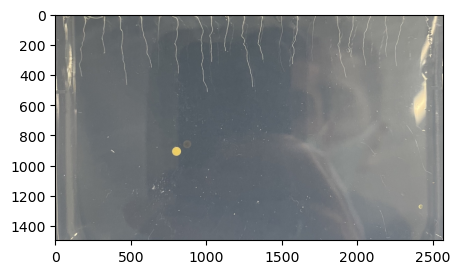

In [4]:
image_initiale= []
image_initiale=skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initiale)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

18 main roots are detected:


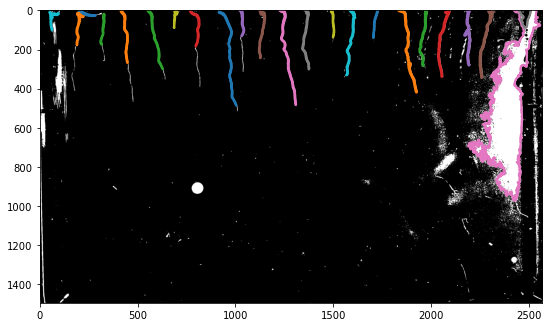

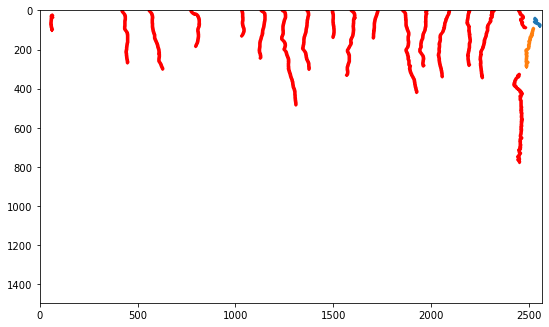

Mode Fast
Error Depth [%]         9.4
Error Length [%]        1.5

In [5]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  
scale= 7.5/image_initiale.shape[0] 

## Mode 'Fast'
metrics_F , df_F = CREATE_Lab(image_initiale,'Fast',nb_roots,'early')
df_F
Accuracy('Fast',metrics_F,depth_gt , length_gt)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

18 main roots are detected:


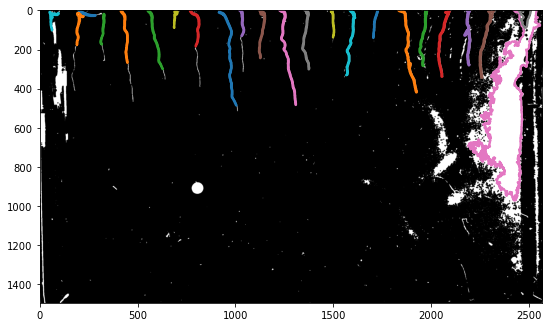

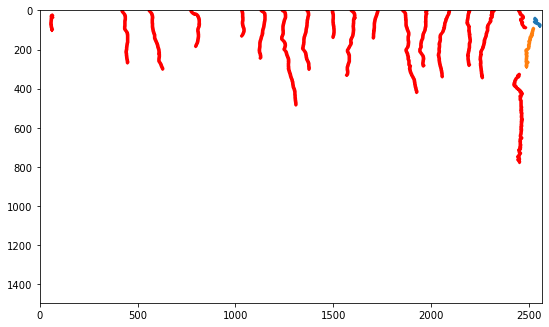

Mode Recommended
Error Depth [%]                9.4
Error Length [%]               1.5

In [6]:
## Mode 'Recommended'
metrics_R , df_R = CREATE_Lab(image_initiale,'Recommended',nb_roots,'early')
df_R
Accuracy('Recommended',metrics_R,depth_gt , length_gt)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

21 main roots are detected:


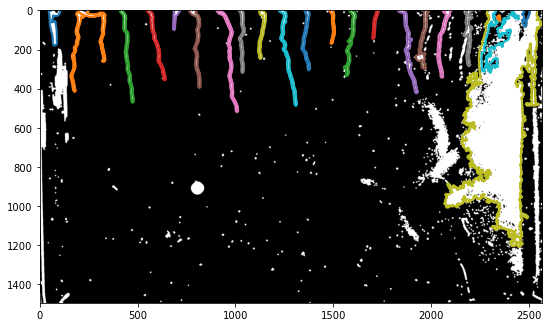

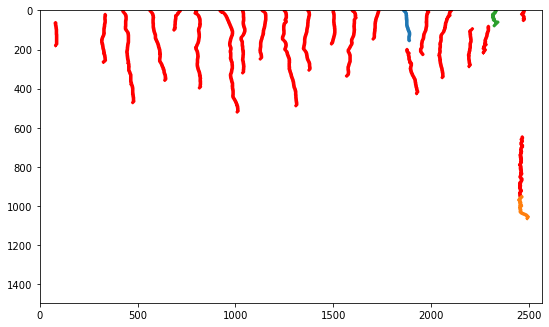

Mode Accurate
Error Depth [%]             7.8
Error Length [%]            2.6

In [7]:
## Mode 'Accurate'
metrics_A , df_A = CREATE_Lab(image_initiale,'Accurate',nb_roots,'early')
df_A
Accuracy('Accurate',metrics_A,depth_gt , length_gt)

In [8]:
# Compare the error between the 3 modes

df2 = pd.DataFrame(np.array([[error_d(metrics_F[0]),error_d(metrics_R[0]),error_d(metrics_A[0])], 
                            [error_l(metrics_F[1]),error_l(metrics_R[1]), error_l(metrics_A[1])]]),
                   columns=[' Mode "Fast" ',' Mode "Recommended" ',' Mode "Accurate" ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2 

Mode "Fast"    Mode "Recommended"   \
Error on the depth measurement [%]             9.4                   9.4   
Error on the length measurement [%]            1.5                   1.5   

                                      Mode "Accurate"   
Error on the depth measurement [%]                 7.8  
Error on the length measurement [%]                2.6

## Influence of dilation - Late stage roots

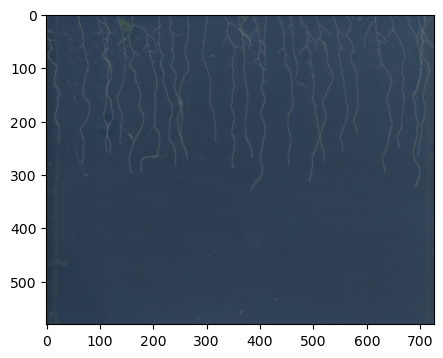

In [9]:
image_initiale= []
image_initiale=skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))


image_initiale= image_initiale[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initiale)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

8 main roots are detected:


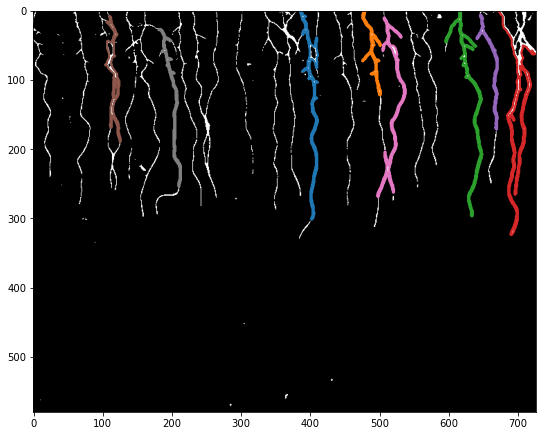

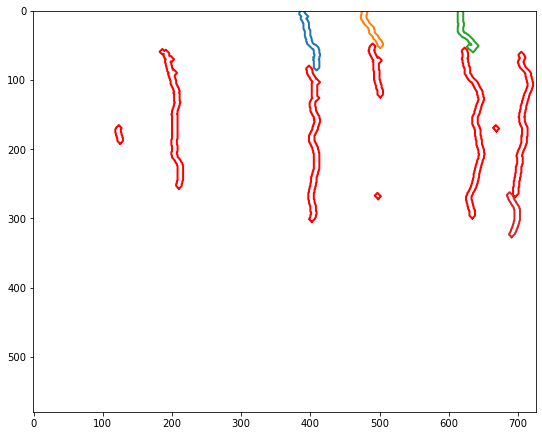

Mode Fast
Error Depth [%]        50.8
Error Length [%]       46.5

In [10]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 
scale= 8.5/image_initiale.shape[0] 


## Mode 'Fast'
metrics_F , df_F = CREATE_Lab(image_initiale,'Fast',nb_roots,'late')
df_F
Accuracy('Fast',metrics_F,depth_gt , length_gt)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


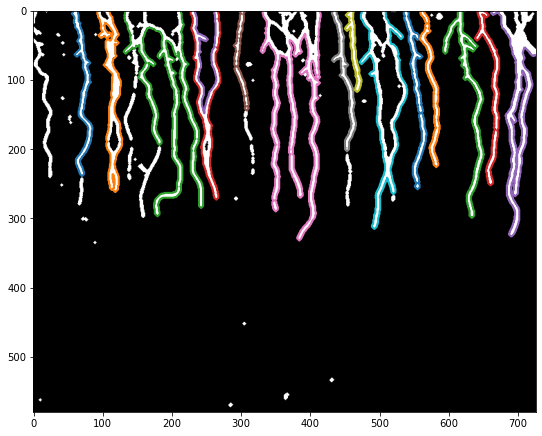

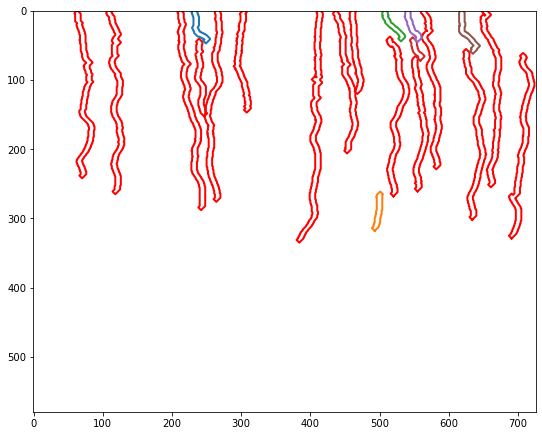

Mode Recommended
Error Depth [%]               11.0
Error Length [%]               3.4

In [11]:
## Mode 'Recommended'
metrics_R , df_R = CREATE_Lab(image_initiale,'Recommended',nb_roots,'late')
df_R
Accuracy('Recommended',metrics_R,depth_gt , length_gt)

<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


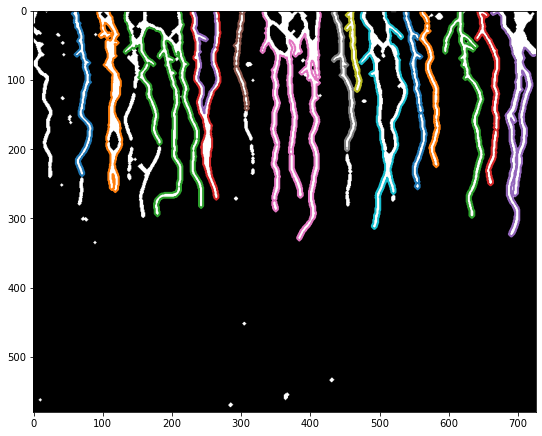

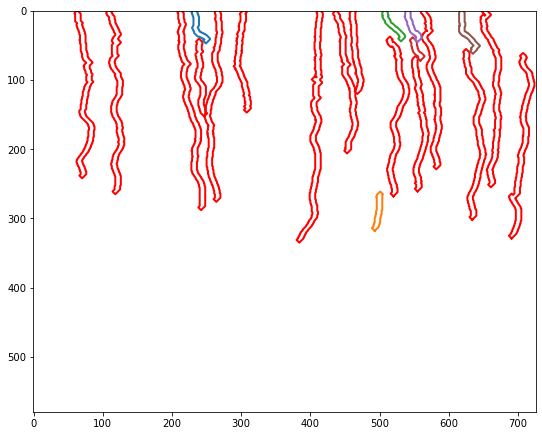

Mode Accurate
Error Depth [%]            11.0
Error Length [%]            3.4

In [12]:
## Mode 'Accurate'
metrics_A , df_A = CREATE_Lab(image_initiale,'Accurate',nb_roots,'late')
df_A
Accuracy('Accurate',metrics_A,depth_gt , length_gt)

In [13]:
# Compare the error between the 3 modes

df2 = pd.DataFrame(np.array([[error_d(metrics_F[0]),error_d(metrics_R[0]),error_d(metrics_A[0])], 
                             [error_l(metrics_F[1]),error_l(metrics_R[1]), error_l(metrics_A[1])]]),
                   columns=[' Mode "Fast" ',' Mode "Recommended" ',' Mode "Accurate" ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
df2 

Mode "Fast"    Mode "Recommended"   \
Error on the depth measurement [%]            50.8                  11.0   
Error on the length measurement [%]           46.5                   3.4   

                                      Mode "Accurate"   
Error on the depth measurement [%]                11.0  
Error on the length measurement [%]                3.4

## Influence of Contrast - Early stage roots

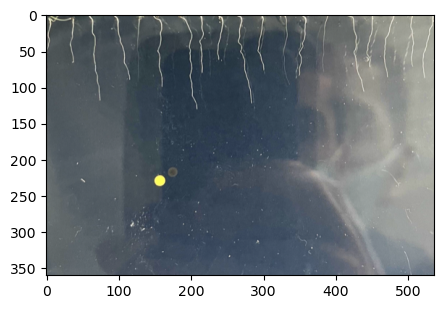

In [14]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/L20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/H20.png'))

image_initialeL80= image_initialeL80[240:600,90:-100,:] 
image_initialeL50= image_initialeL50[240:600,90:-100,:] 
image_initialeL20= image_initialeL20[240:600,90:-100,:] 

#image_initialeI= image_initialeI[240:600,90:-90,:] 

image_initialeH80= image_initialeH80[240:600,90:-100,:] 
image_initialeH50= image_initialeH50[240:600,90:-100,:] 
image_initialeH20= image_initialeH20[240:600,90:-100,:] 


plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeH80)

Contrast: - 80%
 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

12 main roots are detected:


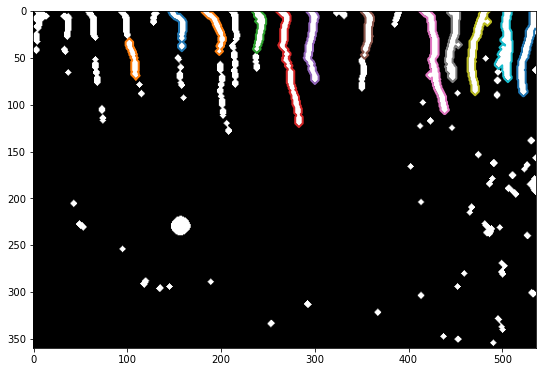

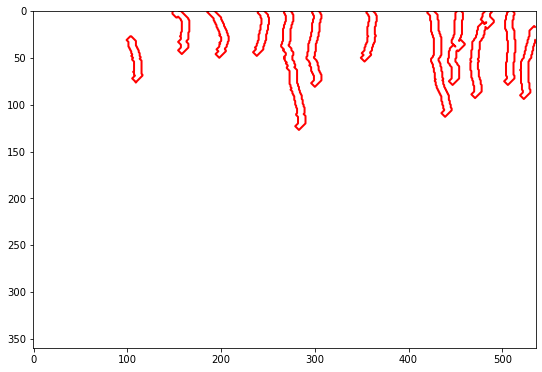

Contrast: - 50%
 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

12 main roots are detected:


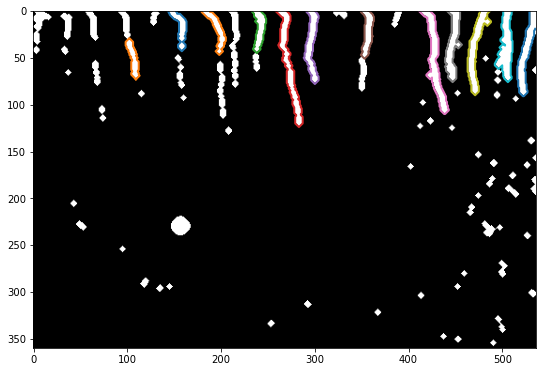

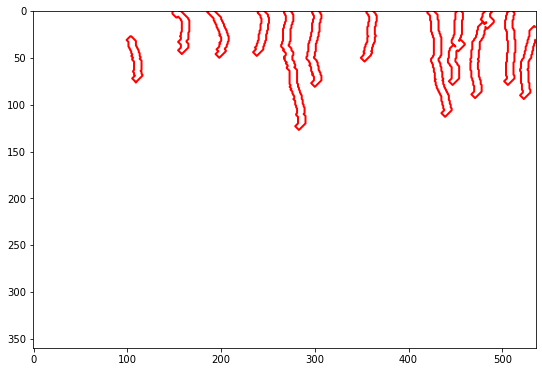

Contrast: - 20%
 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

12 main roots are detected:


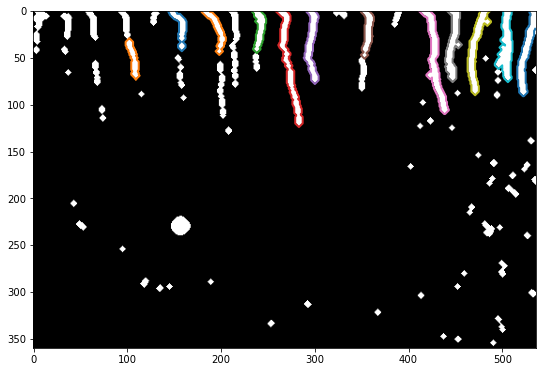

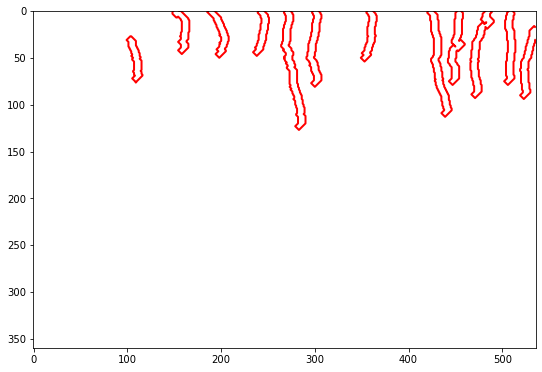

Contrast: 0%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

21 main roots are detected:


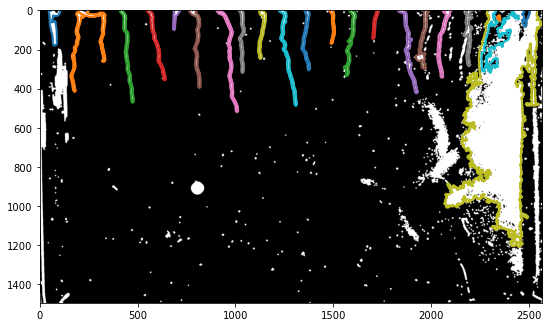

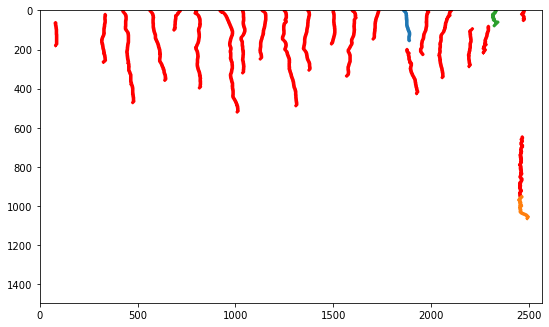

Contrast: + 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

14 main roots are detected:


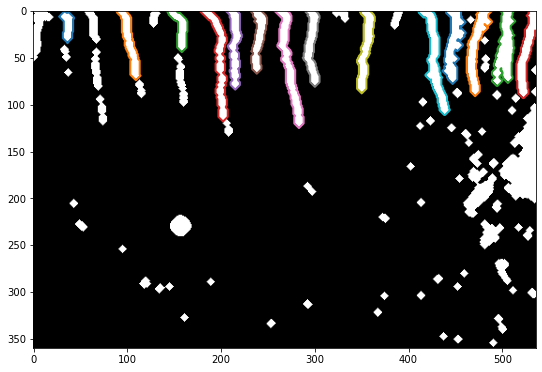

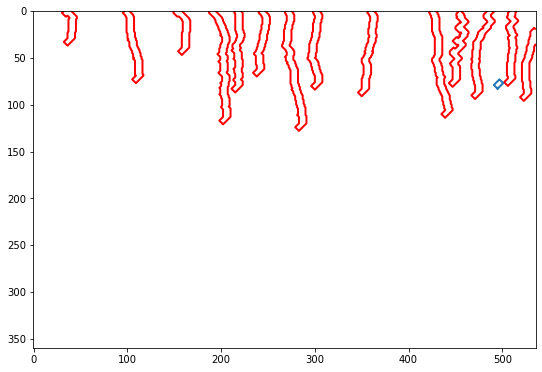

Contrast: + 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


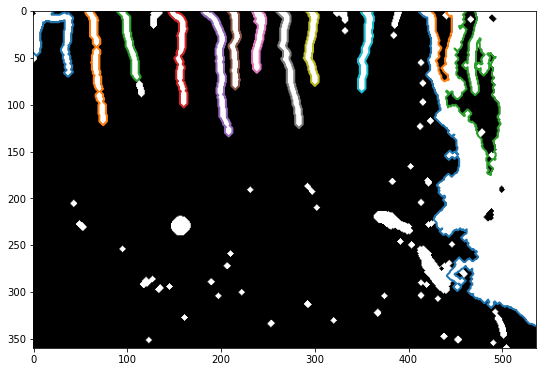

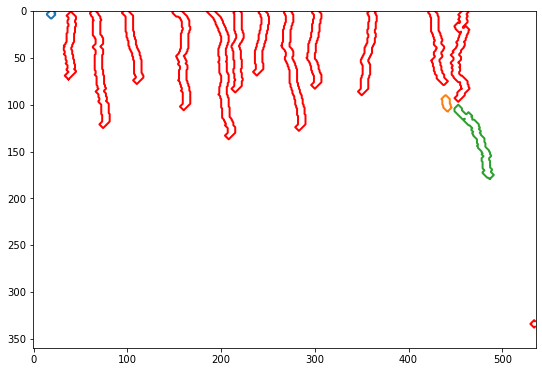

Contrast: + 80%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

14 main roots are detected:


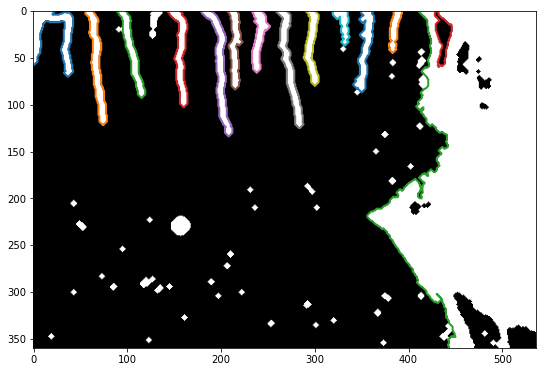

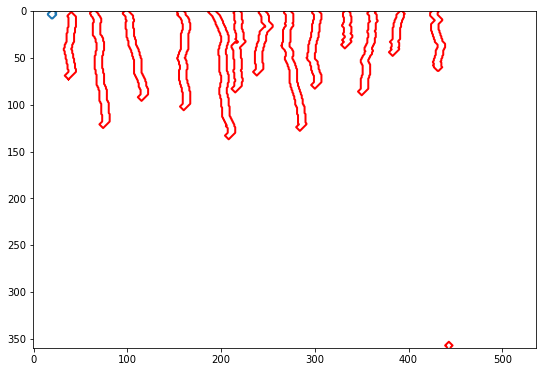

In [15]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  

# Contrast: - 80%
print("Contrast: - 80%")
scale= 7.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'early')

print("Contrast: - 50%")
# Contrast: - 50%
scale= 7.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'early')

print("Contrast: - 20%")
# Contrast: - 20%
scale= 7.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'early')

print("Contrast: 0%")
# Contrast: 0%
scale= 7.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'early')

print("Contrast: + 20%")
# Contrast: + 20%
scale= 7.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'early')

print("Contrast: + 50%")
# Contrast: +50%
scale= 7.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'early')

print("Contrast: + 80%")
# Contrast: +80%
scale= 7.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'early')


In [16]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
print("Influence of Contrast - Early stage roots")
df2

Influence of Contrast - Early stage roots


-80%    -50%    -20%    0%    +20%   \
Error on the depth measurement [%]      3.8     3.8     3.8   7.8    18.0   
Error on the length measurement [%]    17.8    18.0    18.0   2.6    33.5   

                                      +50%    +80%   
Error on the depth measurement [%]     23.8    14.1  
Error on the length measurement [%]    39.6    27.2

## Influence of Brightness - Early stage roots

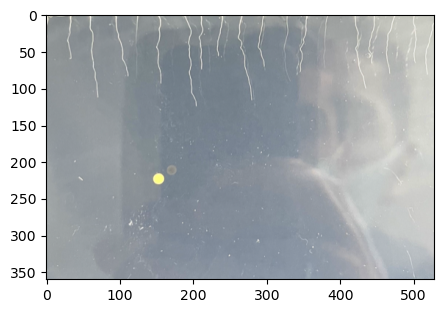

In [17]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BL20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/1:1cbis.jpg'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BH20.png'))

image_initialeL80= image_initialeL80[240:600,90:-100,:] 
image_initialeL50= image_initialeL50[240:600,90:-100,:] 
image_initialeL20= image_initialeL20[240:600,90:-100,:] 

#image_initialeI= image_initialeI[240:600,90:-90,:] 

image_initialeH80= image_initialeH80[240:600,90:-100,:] 
image_initialeH50= image_initialeH50[240:600,90:-100,:] 
image_initialeH20= image_initialeH20[240:600,90:-100,:] 

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeH80)

Brightness: - 80%
 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


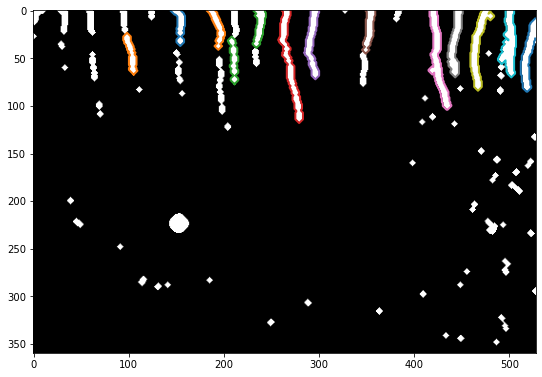

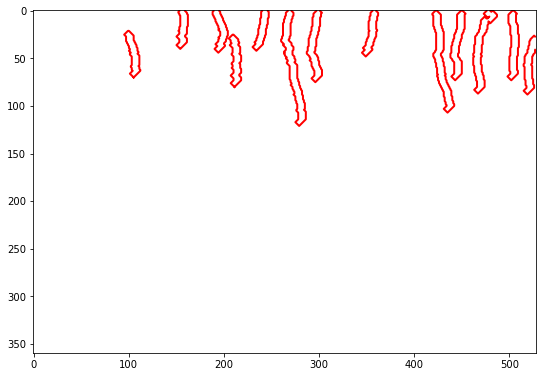

Brightness: - 50%
 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


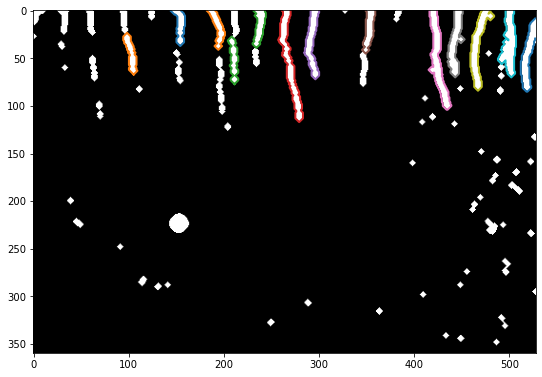

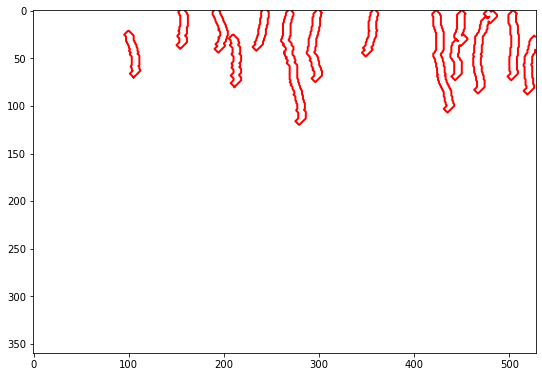

Brightness: - 20%
 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


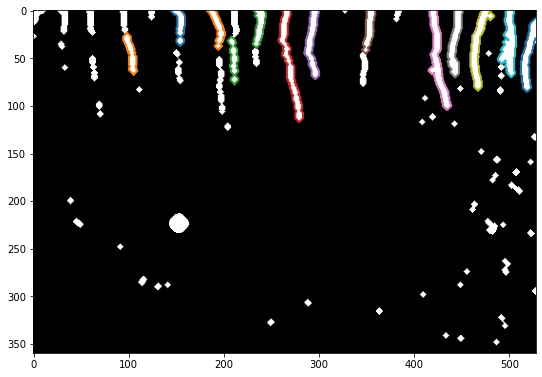

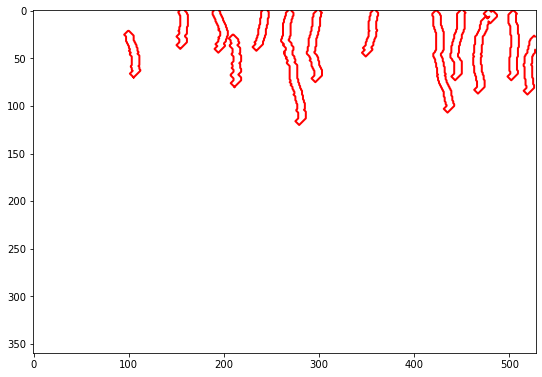

Brightness: 0%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

21 main roots are detected:


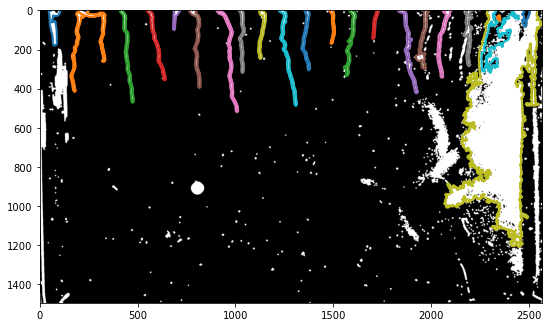

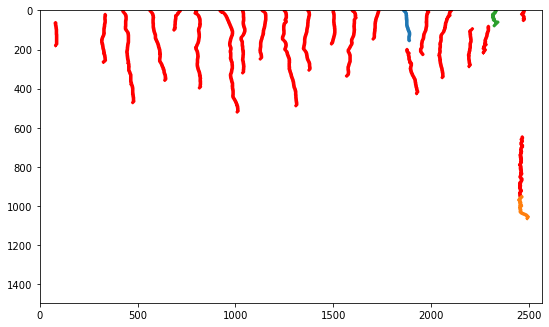

Brightness: + 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


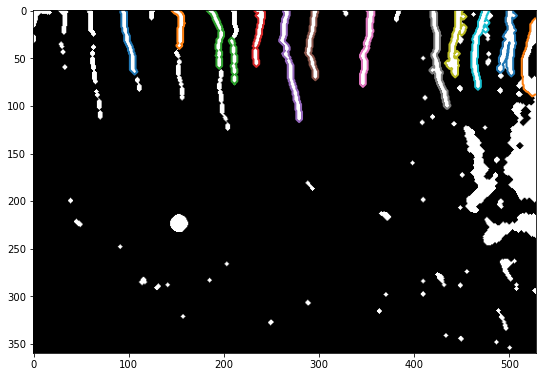

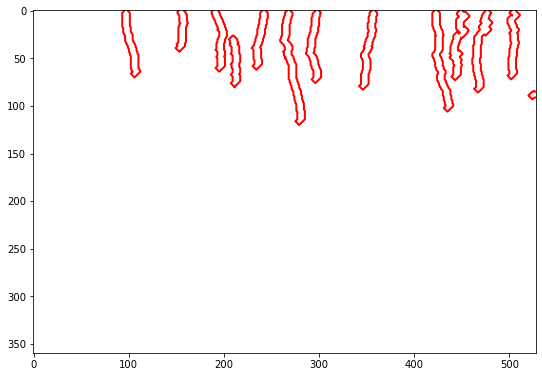

Brightness: + 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

13 main roots are detected:


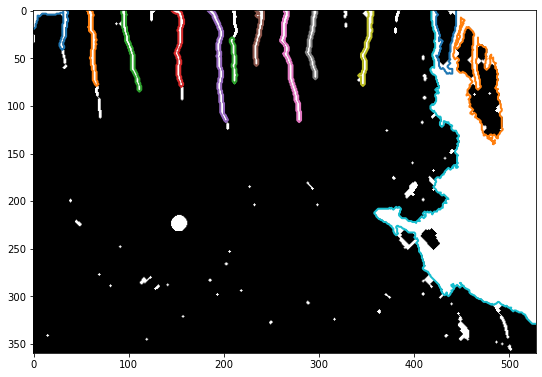

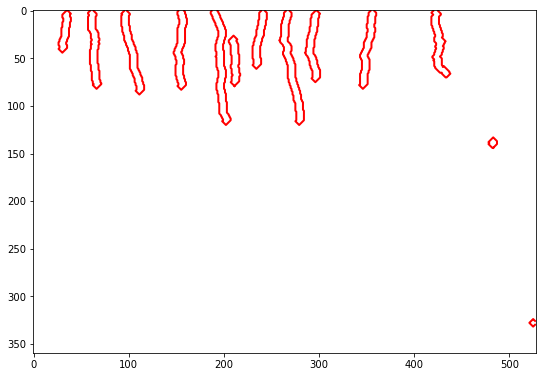

Brightness: + 80%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

14 main roots are detected:


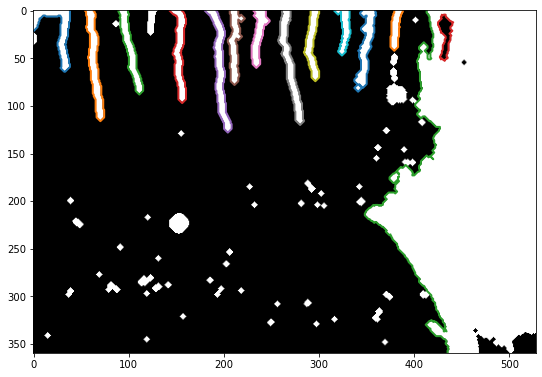

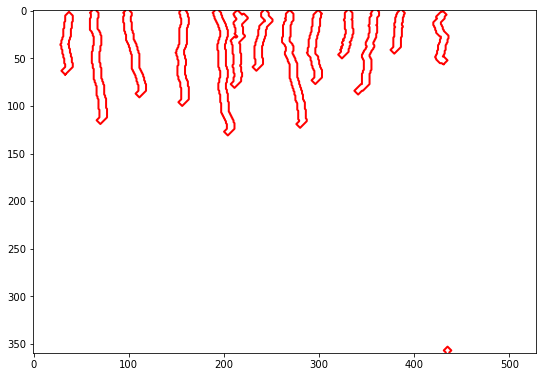

In [18]:
nb_roots=21
depth_gt , length_gt = 1.50, 1.53  

print("Brightness: - 80%")
# Brightness: - 80%
scale= 7.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'early')

print("Brightness: - 50%")
# Brightness: - 50%
scale= 7.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'early')

print("Brightness: - 20%")
# Brightness: - 20%
scale= 7.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'early')

print("Brightness: 0%")
# Brightness: 0%
scale= 7.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'early')

print("Brightness: + 20%")
# Brightness: + 20%
scale= 7.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'early')

print("Brightness: + 50%")
# Brightness: +50%
scale= 7.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'early')

print("Brightness: + 80%")
# Brightness: +80%
scale= 7.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'early')


In [19]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
print("Influence of Brightness - Early stage roots")
df2

Influence of Brightness - Early stage roots


-80%    -50%    -20%    0%    +20%   \
Error on the depth measurement [%]      6.5     6.6     6.6   7.8     1.9   
Error on the length measurement [%]     5.9     6.8     5.9   2.6    10.7   

                                      +50%    +80%   
Error on the depth measurement [%]      4.2     8.7  
Error on the length measurement [%]     5.7    21.4

## Influence of Contrast - Late stage roots

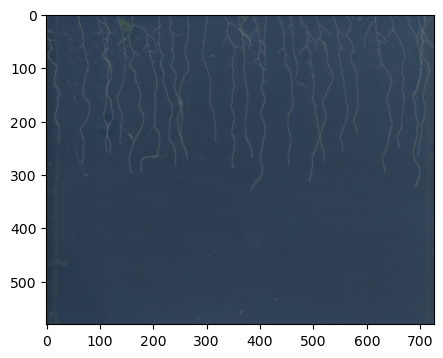

In [20]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CHM20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/CH20.png'))

image_initialeI= image_initialeI[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeI)

Contrast: - 80%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


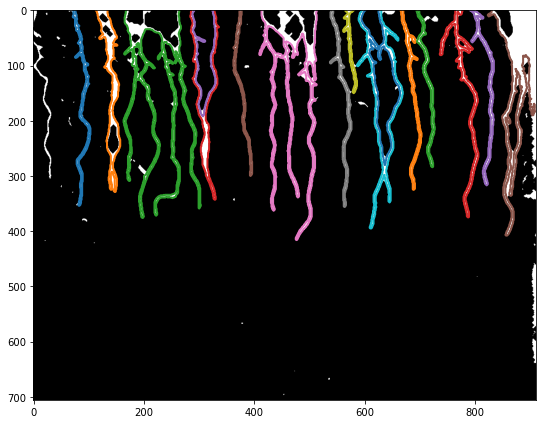

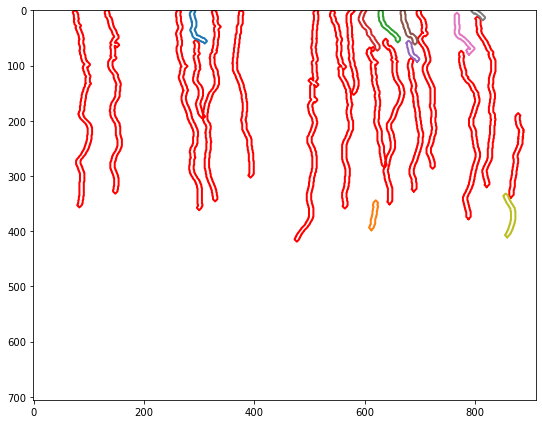

Contrast: - 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

17 main roots are detected:


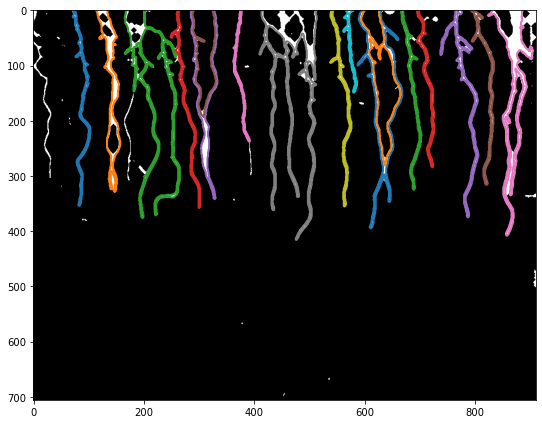

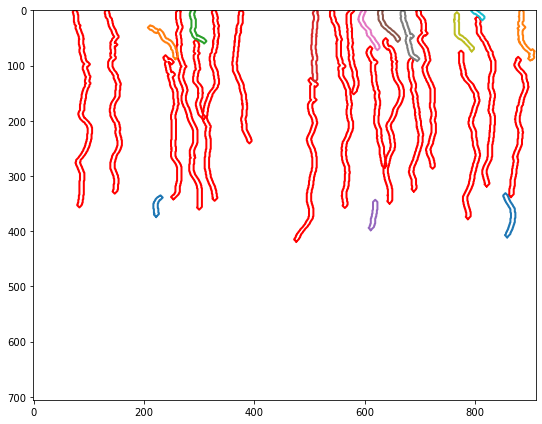

Contrast: - 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


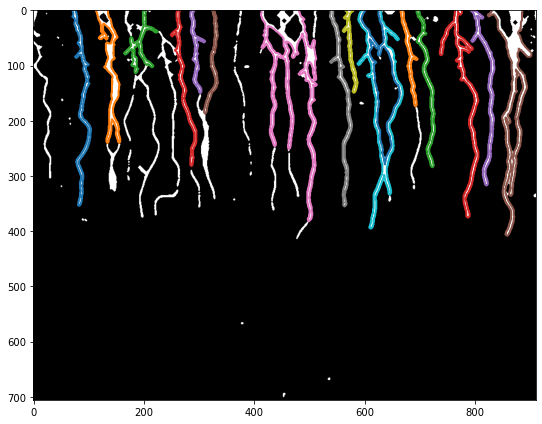

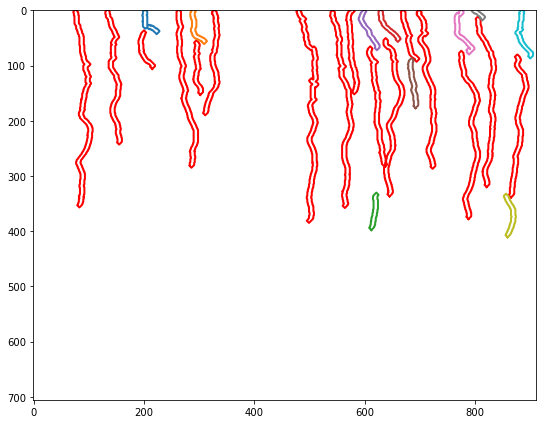

Contrast: 0%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


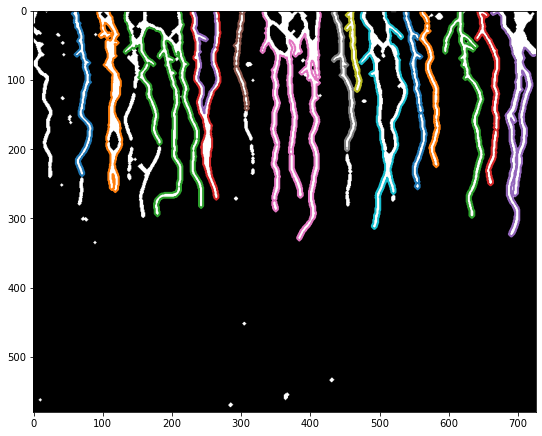

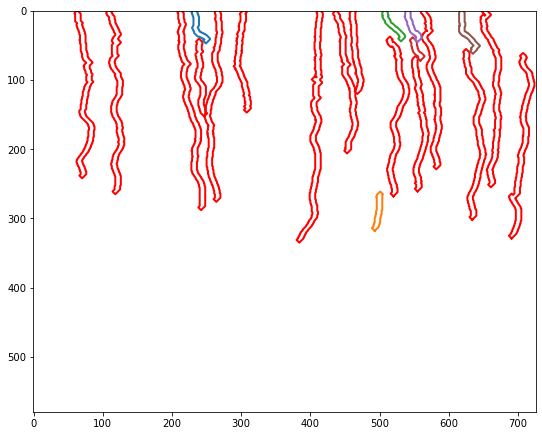

Contrast: + 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


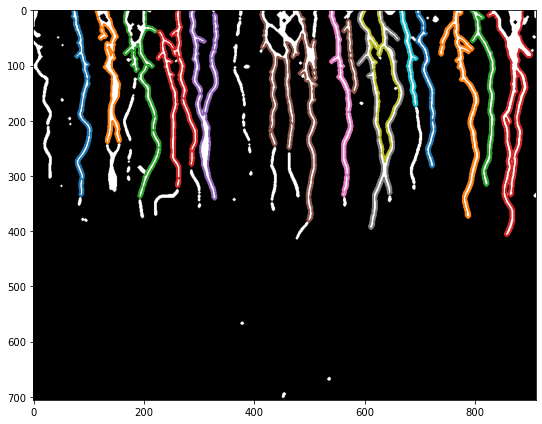

Contrast: + 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

8 main roots are detected:


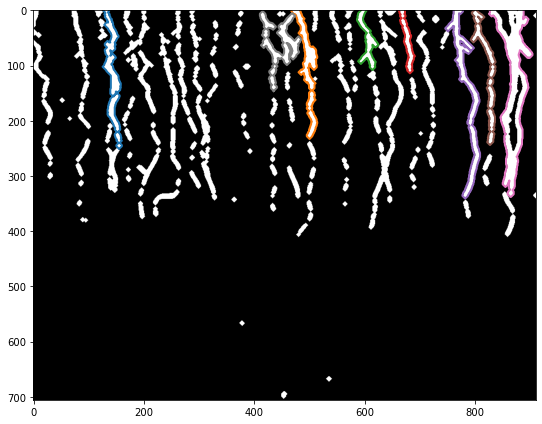

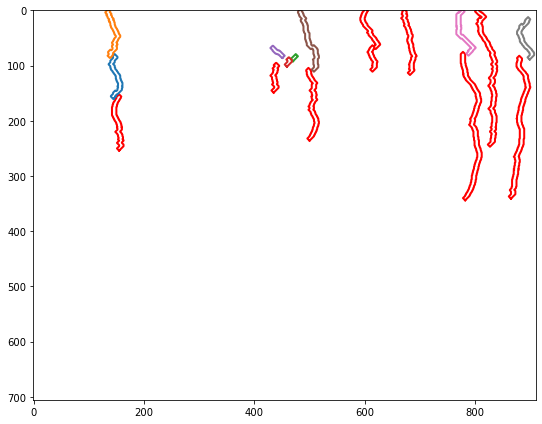

Contrast: + 80%
 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...



<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

1 main roots are detected:


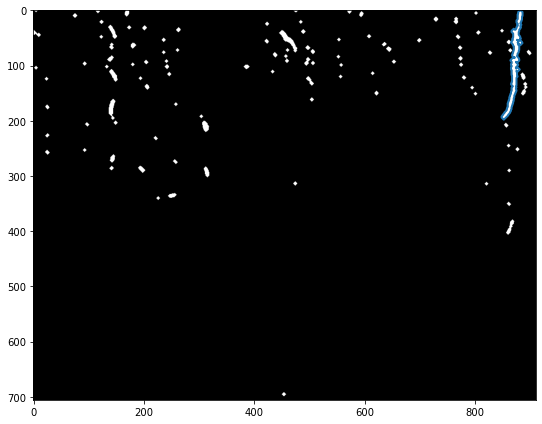

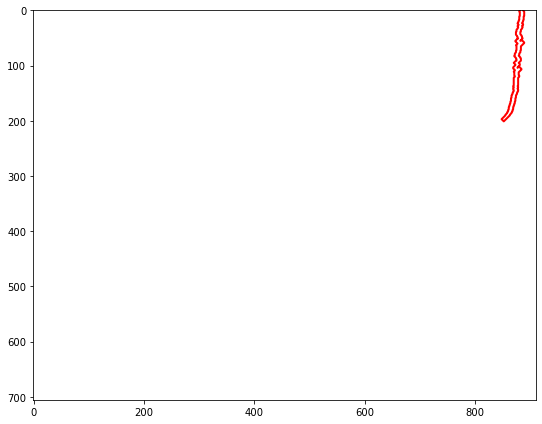

In [21]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 

print("Contrast: - 80%")
# Contrast: - 80%
scale= 8.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'late')

print("Contrast: - 50%")
# Contrast: - 50%
scale= 8.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'late')

print("Contrast: - 20%")
# Contrast: - 20%
scale= 8.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'late')

print("Contrast: 0%")
# Contrast: 0%
scale= 8.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'late')

print("Contrast: + 20%")
# Contrast: + 20%
scale= 8.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'late')

print("Contrast: + 50%")
# Contrast: +50%
scale= 8.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'late')

print("Contrast: + 80%")
# Contrast: +80%
scale= 8.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'late')


In [22]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
print("Influence of Contrast - Late stage roots")
df2

Influence of Contrast - Late stage roots


-80%    -50%    -20%    0%    +20%   \
Error on the depth measurement [%]      8.0    10.0    21.8  11.0    18.0   
Error on the length measurement [%]     1.1     3.3    15.3   3.4    10.0   

                                      +50%    +80%   
Error on the depth measurement [%]     48.2    35.5  
Error on the length measurement [%]    41.3    24.9

## Influence of Brightness - Late stage roots

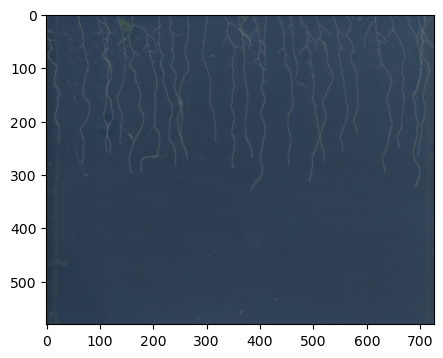

In [23]:
image_initialeL80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL80.png'))
image_initialeL50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL50.png'))
image_initialeL20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBL20.png'))

image_initialeI  = skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/IMAGE2.png'))

image_initialeH80= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH80.png'))
image_initialeH50= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH50.png'))
image_initialeH20= skimage.io.imread(os.path.join(os.pardir, 'PDS-CreateLab/Experiences/MyDataset/BBH20.png'))

image_initialeI= image_initialeI[120:700,40:-50,:] # IMAGE2  Crop the image [vetical axis,horizontal axis,:]

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(image_initialeI)

Brightness: - 80%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


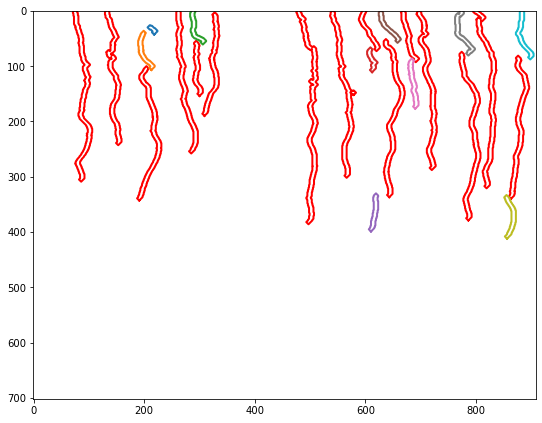

Brightness: - 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


Brightness: - 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


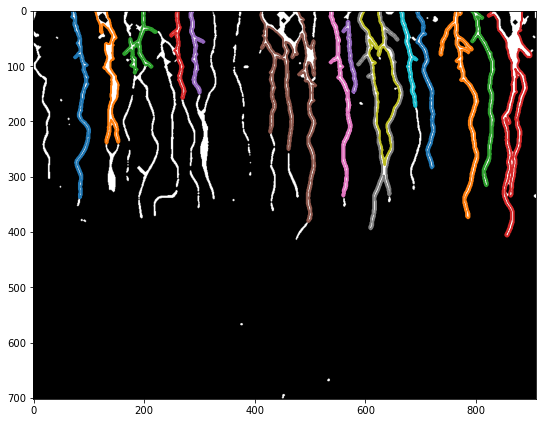

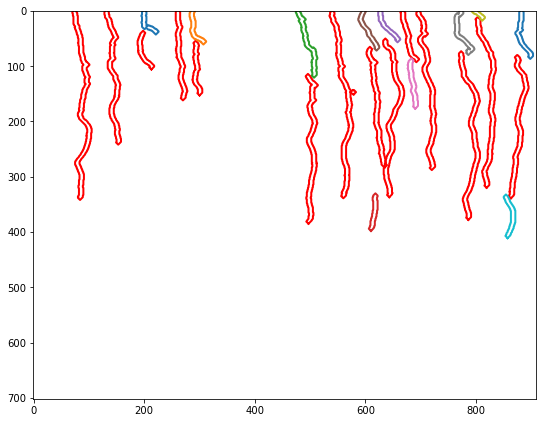

Brightness: 0%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


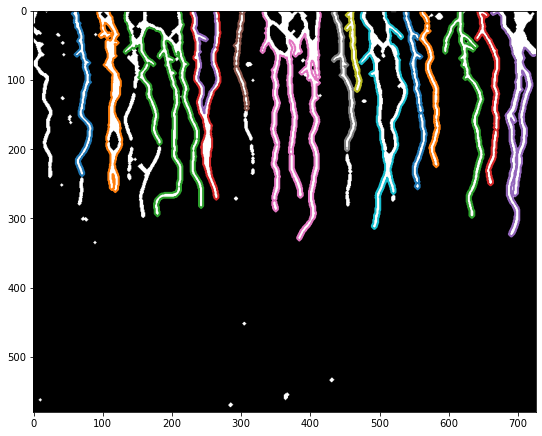

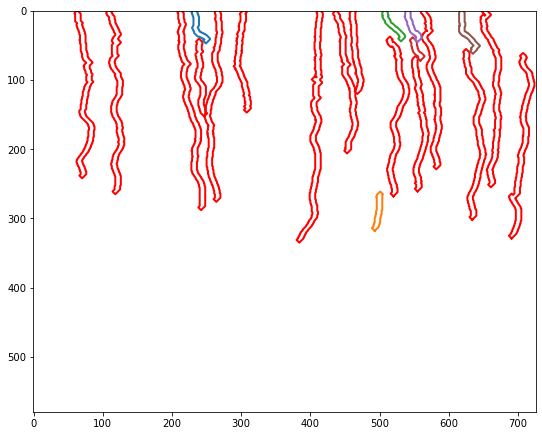

Brightness: + 20%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


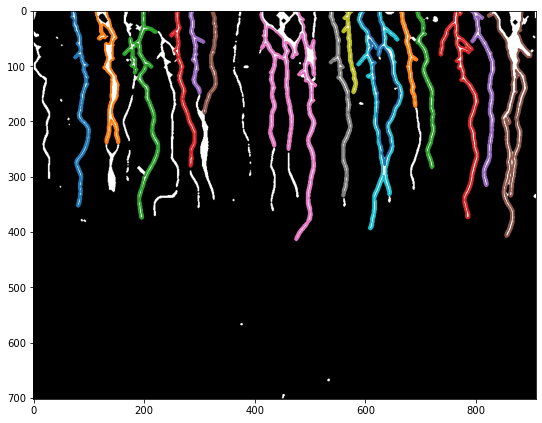

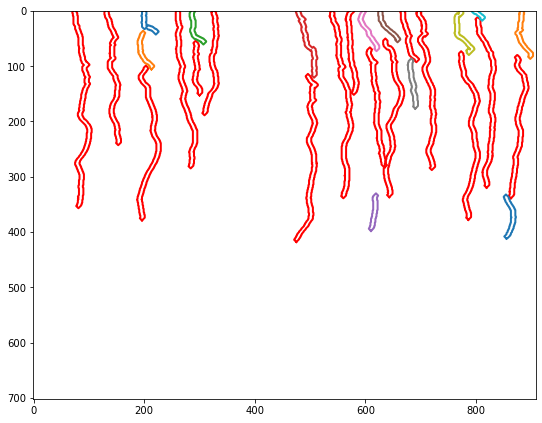

Brightness: + 50%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

16 main roots are detected:


Brightness: + 80%


<ipython-input-2-4ab085096618>:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  contours0.remove([])


 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Fine tuning in progress, please wait ...

 Segmentation of lateral roots in progress, please wait ...

 All Good! Results are ready :p 

15 main roots are detected:


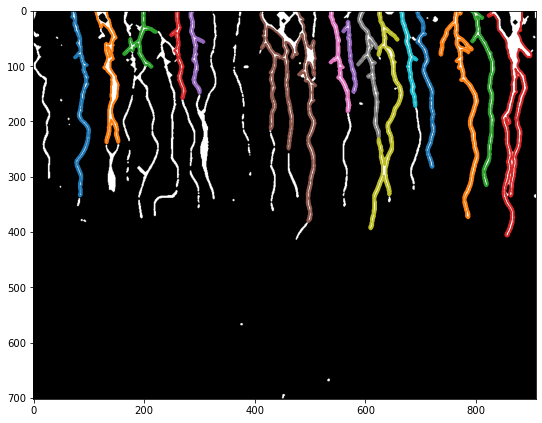

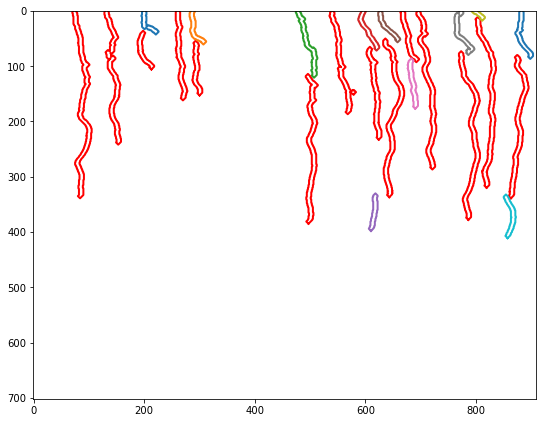

In [24]:
nb_roots=25
depth_gt , length_gt = 3.75, 3.93 

print("Brightness: - 80%")
# Brightness: - 80%
scale= 8.5/image_initialeL80.shape[0] 
metrics_L80 , df_L80 = CREATE_Lab(image_initialeL80,'Accurate',nb_roots,'late')

print("Brightness: - 50%")
# Brightness: - 50%
scale= 8.5/image_initialeL50.shape[0] 
metrics_L50 , df_L50 = CREATE_Lab(image_initialeL50,'Accurate',nb_roots,'late')

print("Brightness: - 20%")
# Brightness: - 20%
scale= 8.5/image_initialeL20.shape[0] 
metrics_L20 , df_L20 = CREATE_Lab(image_initialeL20,'Accurate',nb_roots,'late')

print("Brightness: 0%")
# Brightness: 0%
scale= 8.5/image_initialeI.shape[0] 
metrics_I , df_I     = CREATE_Lab(image_initialeI,'Accurate',nb_roots,'late')

print("Brightness: + 20%")
# Brightness: + 20%
scale= 8.5/image_initialeH20.shape[0] 
metrics_H20 , df_H20 = CREATE_Lab(image_initialeH20,'Accurate',nb_roots,'late')

print("Brightness: + 50%")
# Brightness: +50%
scale= 8.5/image_initialeH50.shape[0] 
metrics_H50 , df_H50 = CREATE_Lab(image_initialeH50,'Accurate',nb_roots,'late')

print("Brightness: + 80%")
# Brightness: +80%
scale= 8.5/image_initialeH80.shape[0] 
metrics_H80 , df_H80 = CREATE_Lab(image_initialeH80,'Accurate',nb_roots,'late')


In [25]:
df2 = pd.DataFrame(np.array([[error_d(metrics_L80[0]),error_d(metrics_L50[0]),error_d(metrics_L20[0]),error_d(metrics_I[0]), error_d(metrics_H20[0]), error_d(metrics_H50[0]), error_d(metrics_H80[0])], 
                             [error_l(metrics_L80[1]),error_l(metrics_L50[1]),error_l(metrics_L20[1]),error_l(metrics_I[1]), error_l(metrics_H20[1]), error_l(metrics_H50[1]), error_l(metrics_H80[1])]]),
                   columns=[' -80% ',' -50% ',' -20% ',' 0% ',' +20% ',' +50% ',' +80% ' ])
df2.index = ['Error on the depth measurement [%]','Error on the length measurement [%]']
df2=df2.round(1)
print("Influence of Brightness - Late stage roots")
df2

Influence of Brightness - Late stage roots


-80%    -50%    -20%    0%    +20%   \
Error on the depth measurement [%]     26.1    30.0    29.1  11.0    19.1   
Error on the length measurement [%]    18.5    22.9    23.1   3.4    12.5   

                                      +50%    +80%   
Error on the depth measurement [%]     16.8    33.6  
Error on the length measurement [%]    10.0    27.4